In [97]:
import numpy as np
import torch
from torch import optim
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import urllib
import time
import os
import shutil
from sklearn.metrics import f1_score as f1, accuracy_score as acc, recall_score as recall
import optuna
import mlflow
import mlflow.pytorch
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')



# Scraping the web for images

## Using Chrome browser and google images

In [98]:
def get_images(phrase: str, class_contains: str, min_width=64, min_height=64):

    service = Service('path/to/chromedriver')

    # Initialize the WebDriver
    driver = webdriver.Chrome()

    url = "https://www.google.com/search?q={s}&tbm=isch&tbs=sur%3Afc&hl=en&ved=0CAIQpwVqFwoTCKCa1c6s4-oCFQAAAAAdAAAAABAC&biw=1251&bih=568"
    driver.get(url.format(s=f'{phrase}'))
    for j in range(10):
        driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
        time.sleep(2)
    # retrieve image information
    imgResults = driver.find_elements(By.XPATH, f"//img[contains(@class,'{class_contains}')]")
    # retrieve image attribute
    src = []
    for img in imgResults:
        if (int(img.get_attribute('width')) > min_width) & (int(img.get_attribute('height')) > min_height):
            src.append(img.get_attribute('src'))
    # Download the images
    for i in range(len(src)):
        urllib.request.urlretrieve(str(src[i]), f"data/scraped_images/{phrase}{i}.jpg")

### Script below commented out because images have been scraped already.

In [99]:
#get_images('car', 'YQ4gaf')

In [100]:
#get_images('ship', 'YQ4gaf')

In [101]:
#get_images('plane', 'YQ4gaf')

After scraping the images, I manually deleted inappropriately labelled images

## Rename Images: reset image numbers

In [102]:
def rename_images(starts_with: str):

    # Define source and destination directories
    source_dir = "scraped_images"
    destination_dir = "data/scraped_images_serialized"

    # Ensure destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Iterate over files in the source directory
    for serial, filename in enumerate(os.listdir(source_dir)):
        # Check if the file starts with 'starts_with'
        if filename.startswith(starts_with):
            # Construct full file paths
            source_path = os.path.join(source_dir, filename)
            # Check if it's a file (not a directory)
            if os.path.isfile(source_path):
                # Rename file
                new_name = f"{starts_with}{serial}{os.path.splitext(filename)[1]}"
                destination_path = os.path.join(destination_dir, new_name)
                # Move and rename the file
                shutil.move(source_path, destination_path)
                print(f"Moved {filename} to {destination_path}")



In [103]:
'''rename_images('car')
rename_images('ship')
rename_images('plane')'''


"rename_images('car')\nrename_images('ship')\nrename_images('plane')"

## Read scraped images
I filtered out grayscale images

In [146]:
from PIL import Image
import re
label_dict = {0: 'car',
              1: 'plane',
              2: 'ship'}

image_tensor = []
labels = []

for image in os.listdir("data/scraped_images_serialized"):
    img = Image.open(f'data/scraped_images_serialized/{image}')
    if img.mode == "RGB":  # Only include RGB images
        # resize image and add to list
        img_resized = img.resize((224, 224))
        image_tensor.append(img_resized)  # Convert to numpy array for stacking

        # extract label name using regex
        pattern = r'[a-zA-Z]+'

        # match alphabetic characters only
        alph = re.match(pattern, image)[0]

        # reverse key and values of dict
        label_dict_reverse = {v: k for k, v in label_dict.items()}

        labels.append(label_dict_reverse[alph])

image_tensor = np.stack(image_tensor, axis=0) # stack RGB images along first axis
labels = np.array(labels)


In [147]:
# number of images per class
for i in np.unique(labels):
    print(f'Count of {label_dict[i]} images = {len(labels[labels == i])}')

Count of car images = 255
Count of plane images = 375
Count of ship images = 255


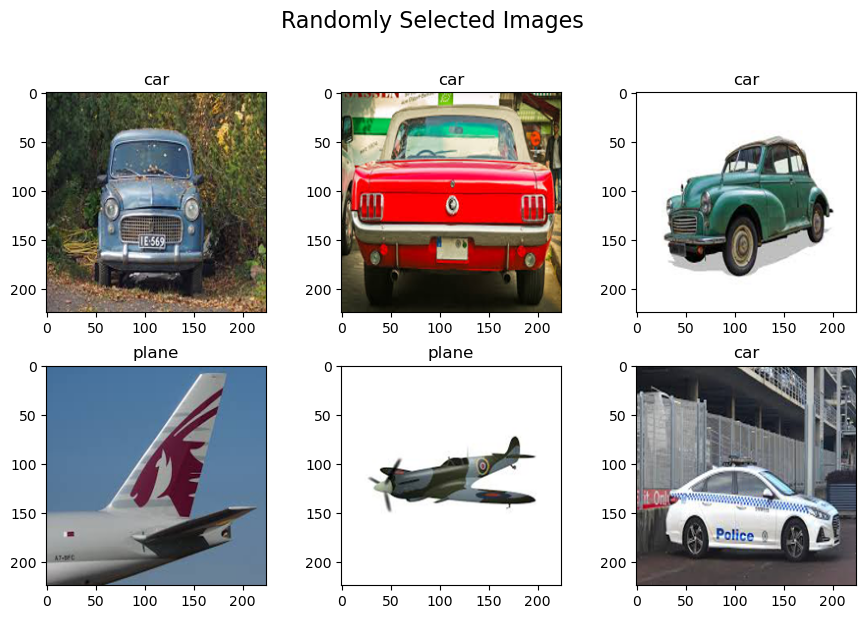

In [148]:
# plot 5 random images from dataset with their class name as title
from random import randint

fig, axes = plt.subplots(2, 3, figsize=(3*3, 3*2))
fig.suptitle('Randomly Selected Images', fontsize=16, y=1.02)

# Generate random indices
rand_indices = [randint(0, image_tensor.shape[0]) for j in range(6)]

# Flatten axes
axes = axes.flatten()

for idx, ax in enumerate(axes):

    # Get image at current index
    img = image_tensor[rand_indices[idx]]
    ax.imshow(img)

    ax.set_title(f'{label_dict[labels[rand_indices[idx]]]}')


plt.tight_layout()

## Reshape tensors for PyTorch DataLoader then standardize them

In [149]:
from torch.utils.data import DataLoader, TensorDataset

# Transpose the image tensor to (number of images, number of channels, height, width)
image_tensor_tor = torch.tensor(image_tensor).permute(0, 3, 1, 2)  # From (N, W, H, 3) to (N, 3, H, W)

# Normalize images
image_tensor_tor = image_tensor_tor / 255.0  # Normalize to [0, 1]
mean = image_tensor_tor.mean(dim=(0, 2, 3), keepdim=True)
std = image_tensor_tor.std(dim=(0, 2, 3), keepdim=True)
image_tensor_tor = (image_tensor_tor - mean) / std  # Standardize


## Obtain train & test sets

The test set will be left for the final best model after performing Bayesian optimization. Best model will be picked based on cross-validated performance of f1-macro score.

In [150]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_idx, test_idx, _, _ = train_test_split(
    range(image_tensor_tor.shape[0]), labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_images = image_tensor_tor[train_idx].float().clone().detach()
test_images = image_tensor_tor[test_idx].float().clone().detach()
train_labels = torch.tensor(labels[train_idx], dtype=torch.int64)
test_labels = torch.tensor(labels[test_idx], dtype=torch.int64)

## Create DataLoaders for the CNN

In [13]:
# Create Tensor Datasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Seed function for reproducability

def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [15]:
height = image_tensor_tor.shape[2]
width = image_tensor_tor.shape[3]
num_classes = len(np.unique(labels))

## CNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as func

class SimpleCNN(nn.Module):

    def __init__(self, seed=42):
        super(SimpleCNN, self).__init__()
        set_seed(seed)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # in_ch 3 -> 16 out_ch
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # in_ch 16 -> 32 out_ch
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by 2
        self.fc1 = nn.Linear(32 * (224 // 4) * (224 // 4), 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = func.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleCNN().to('cpu') #.to(device) # Moved to cpu while building docker container to avoid installing cuda


Using device: cuda


# Main Code
- **Bayesian optimization** for hyperparameters tuning
- Experiment logging using **MLflow**


In [16]:
# Objective function prepared for Optuna hyperparameter tuning
def objective(trial, verbose=False):

    '''Suggest hyperparameters - sets lower and upper bounds, optuna fits a surrogate model to find the best parameters - I optimized the learning rate, weight decay (l2 penalty), and the number of epochs. The surrogate model estimates these 3 parameters by fitting a surrogate model and tries to maximize my metric of choice - in this case the cross validated f1-macro score.'''

    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int("num_epochs", 10, 30)

    # Log parameters to MLflow
    with mlflow.start_run():
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("weight_decay", weight_decay)

        # Initialize KFold
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # store cross-validation F1 scores
        fold_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
            # Split data for the current fold
            train_fold_images = train_images[train_idx]
            train_fold_labels = train_labels[train_idx]
            val_fold_images = train_images[val_idx]
            val_fold_labels = train_labels[val_idx]

            # Create DataLoaders
            train_dataset_fold = TensorDataset(train_fold_images, train_fold_labels)
            val_dataset_fold = TensorDataset(val_fold_images, val_fold_labels)
            train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
            val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

            set_seed(42)
            # Initialize model and optimizer
            model = SimpleCNN(seed=42).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = nn.CrossEntropyLoss()
            if verbose:
                print(f"### Fold {fold + 1} Training - Number of epochs: {num_epochs} ###")

            # Training Loop
            for epoch in range(num_epochs):
                model.train()
                for inpt, trgt in train_loader_fold:
                    inpt, trgt = inpt.to(device), trgt.to(device)
                    optimizer.zero_grad()
                    outpt = model(inpt)
                    loss = criterion(outpt, trgt)
                    loss.backward()
                    optimizer.step()

            # Validation Loop
            model.eval()
            predictions = []
            labels_val = []
            with torch.no_grad():
                for inpt, trgt in val_loader_fold:
                    inpt, trgt = inpt.to(device), trgt.to(device)
                    outpt = model(inpt)
                    _, predicted = torch.max(outpt, 1)
                    predictions.append(predicted)
                    labels_val.append(trgt)

            # Flatten predictions and labels
            predictions = [j.cpu() for i in predictions for j in i]
            labels_val = [j.cpu() for i in labels_val for j in i]

            # Compute F1 Macro for the fold
            f1_macro = f1(labels_val, predictions, average="macro")
            fold_scores.append(f1_macro)
            if verbose:
                print(f"\t F1 Macro: {f1_macro:.4f}")

        # Average F1 Macro across folds
        f1_macro_cv_avg = np.mean(fold_scores)
        if verbose:
            print(f"Average F1 Macro across folds: {f1_macro_cv_avg:.4f}")

        # Log the average metric to MLflow
        mlflow.log_metric("f1_macro_cv_avg", f1_macro_cv_avg)

        '''# Save the trained model
        mlflow.pytorch.log_model(model, artifact_path="model")'''

        return f1_macro_cv_avg

## Run the Main Code

In [17]:
# Run Bayesian optimization with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Retrieve best hyperparameters
best_params = study.best_params
best_score = study.best_value
print("Best hyperparameters:", best_params)
print("Best f1 macro:", best_score)

[I 2025-01-03 11:21:56,840] A new study created in memory with name: no-name-51efce0f-d770-4c6c-a53f-fa19abd74c26
[I 2025-01-03 11:22:41,891] Trial 0 finished with value: 0.743304313439003 and parameters: {'learning_rate': 0.00013650309426345038, 'weight_decay': 1.045581680110081e-05, 'num_epochs': 21}. Best is trial 0 with value: 0.743304313439003.
[I 2025-01-03 11:23:26,396] Trial 1 finished with value: 0.3622331967220436 and parameters: {'learning_rate': 0.006587238857184555, 'weight_decay': 0.0028147598702790034, 'num_epochs': 21}. Best is trial 0 with value: 0.743304313439003.
[I 2025-01-03 11:24:27,380] Trial 2 finished with value: 0.6897123010565323 and parameters: {'learning_rate': 0.0015111737229701453, 'weight_decay': 0.0017040458900408513, 'num_epochs': 29}. Best is trial 0 with value: 0.743304313439003.
[I 2025-01-03 11:24:51,073] Trial 3 finished with value: 0.19504995932303393 and parameters: {'learning_rate': 0.009463328443067286, 'weight_decay': 0.0006887878630707886, '

Best hyperparameters: {'learning_rate': 0.00017289990320993549, 'weight_decay': 0.0003483137622259508, 'num_epochs': 24}
Best f1 macro: 0.7589705688474425


# Refit best model using all training data and save model:

In [24]:
def refit_and_evaluate_best_model(best_params):
    print("Refitting model with the best hyperparameters...")
    # Best hyperparameters
    lr = best_params["learning_rate"]
    weight_decay = best_params["weight_decay"]
    num_epochs = best_params["num_epochs"]

    # Start MLflow run for the final model
    with mlflow.start_run(run_name="final_model"):
        # Log the best parameters
        mlflow.log_params(best_params)

        set_seed(42)
        model = SimpleCNN(seed=42).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train on full training data
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inpt, trgt in train_loader:
                inpt, trgt = inpt.to(device), trgt.to(device)
                optimizer.zero_grad()
                outpt = model(inpt)
                loss = criterion(outpt, trgt)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Log training loss per epoch
            mlflow.log_metric("train_loss", epoch_loss / len(train_loader), step=epoch)

        # Evaluate on the test set
        model.eval()
        predictions = []
        labels_ts = []
        with torch.no_grad():
            for inpt, trgt in test_loader:
                inpt, trgt = inpt.to(device), trgt.to(device)
                outpt = model(inpt)
                _, predicted = torch.max(outpt, 1)
                predictions.append(predicted)
                labels_ts.append(trgt)

        # Flatten predictions and labels
        predictions = [j.cpu().item() for i in predictions for j in i]
        labels_ts = [j.cpu().item() for i in labels_ts for j in i]

        # Compute Test F1 Macro
        test_f1_macro = f1(labels_ts, predictions, average="macro")

        # Log final metrics
        mlflow.log_metrics({
            "test_f1_macro": test_f1_macro,
            "test_accuracy": acc(labels_ts, predictions),
            "test_recall": recall(labels_ts, predictions, average="macro")
        })

        # Move model to cpu so when we build container we wouldn't need cuda dependencies
        model = model.cpu().eval()

        # Save in PyTorch format
        torch.save(model, f'best_model/CNN_best_model-f1_{test_f1_macro:.4f} - full.pth')
        print("Model saved in PyTorch format for deployment.")

        # Move model back to original devic for further use
        model.to(device)

        return test_f1_macro, predictions, labels_ts

# Refit model with the best hyperparameters and evaluate
test_f1_macro, preds, labels_ts = refit_and_evaluate_best_model(best_params)
print(f"Final Test F1 Macro: {test_f1_macro:.4f}")

Refitting model with the best hyperparameters...


Registered model 'image_classifier' already exists. Creating a new version of this model...


Final Test F1 Macro: 0.7887


Created version '2' of model 'image_classifier'.


In [31]:
# Get the run ID
latest_run_id = mlflow.search_runs(order_by=["start_time DESC"]).iloc[0].run_id
print(f"Latest run ID: {latest_run_id}")  # Copy this ID

Latest run ID: f1aa76f0d6b14c30989c463bc11b112f


In [26]:
# run this command in windows terminal after starting Docker to build image
'''mlflow models build-docker -m "runs:/f1aa76f0d6b14c30989c463bc11b112f" -n "image_classifier_cpu"'''

'mlflow models build-docker -m "runs:/aeea57d7e44047bb806827411bebaf20/model" -n "image_classifier_cpu"'

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(labels_ts, preds)
print(confusion_matrix)

[[43  7  2]
 [ 5 71  6]
 [ 4 11 28]]


In [28]:
# test dataset indices of misclassified images
idx_miss = np.where(np.array(preds) != np.array(labels_ts))[0]

## Plot misclassified images (predicted label between brackets)

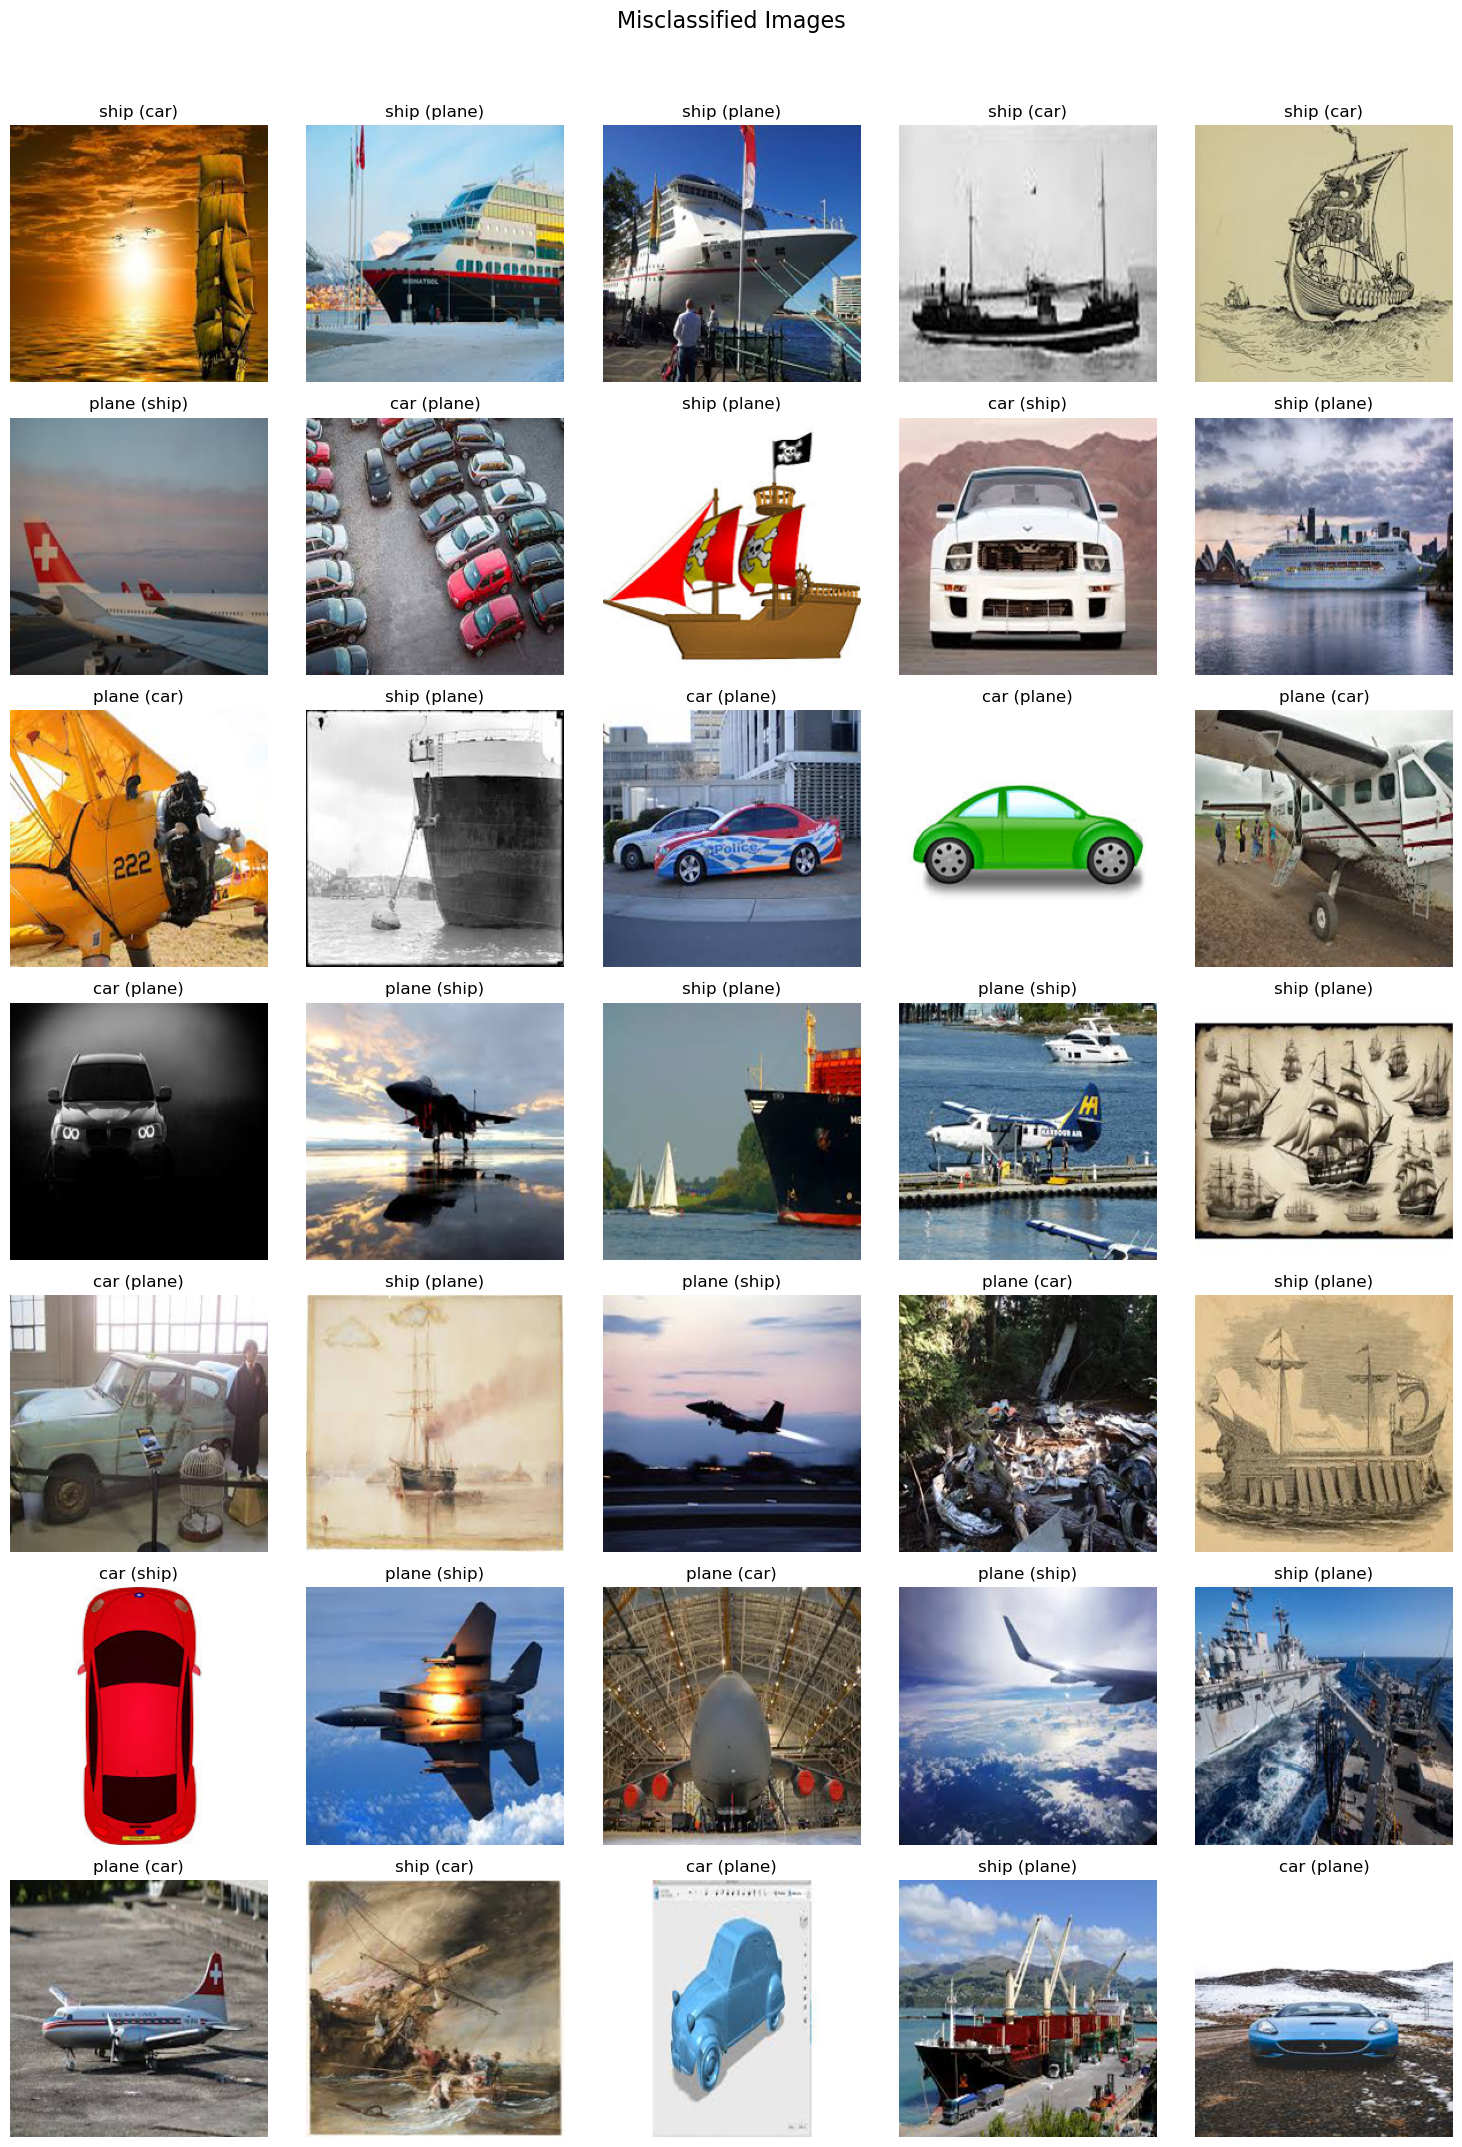

In [30]:
images_reverse_std = image_tensor_tor * std + mean

# Number of images to plot
n_images = len(idx_miss)

# Number of rows needed
nrows = int(np.ceil(n_images / 5))

# Create subplots
fig, axes = plt.subplots(nrows, 5, figsize=(3*5, 3*nrows))
fig.suptitle('Misclassified Images', fontsize=16, y=1.02)

axes = axes.flatten()

# Plot each image
for idx, ax in enumerate(axes):
    if idx < n_images:
        # Get image at current index
        img = images_reverse_std[test_idx][idx_miss[idx]]

        # Transform from (3, H, W) to (H, W, 3) for plotting
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{label_dict[labels_ts[idx_miss[idx]]]} ({label_dict[preds[idx_miss[idx]]]})')
    else:
        # Turn off empty subplots
        ax.axis('off')

plt.tight_layout()
plt.show()

# Test inference of single image by loading the saved best model

Here I'm only testing the saved model to figure out what kind of preprocessing will be needed in the API

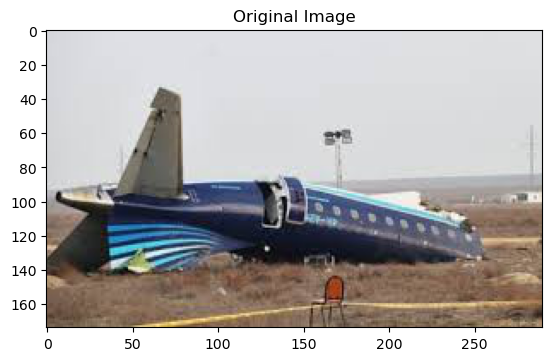

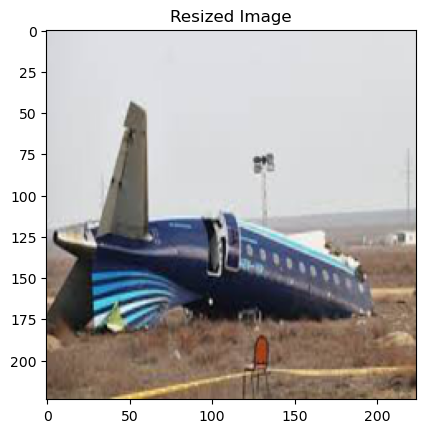

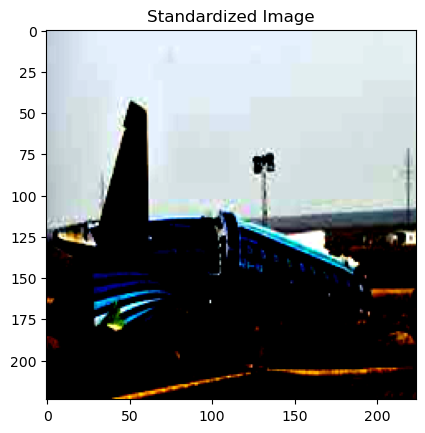

Predicted class: ### Plane ###
CNN output layer probailities: {'Car': 0.004, 'Plane': 0.972, 'Ship': 0.024}


In [65]:
from PIL import Image
import torch
import numpy as np
import torchvision.transforms as transforms

# Paths
path1 = 'best_model/CNN_best_model-f1_0.7887.pth'
image_path = "data/inference test/inf11_plane.jpg"

# Load the model
model_r = SimpleCNN(1)
model_r.load_state_dict(torch.load(path1))
model_r = model_r.eval()  # Ensure the model is in evaluation mode

# Open and preprocess the image
img = Image.open(image_path)
plt.imshow(img)
plt.title('Original Image')
plt.show()

# Image preprocessing
# Convert image
img = img.convert('RGB').resize((224, 224))
img = np.stack((img,) , axis=-1)
plt.imshow(img[:,:,:,0])
plt.title('Resized Image')
plt.show()
# Transpose the image tensor to (number of images, number of channels, height, width)
img_tor = torch.tensor(img).permute(3, 2, 0, 1)  # From (W, H, 3, N) to (N, 3, H, W)

# Normalize image
img_tor = img_tor / 255.0  # Normalize to [0, 1]
mean_tor = img_tor.mean(dim=(0, 2, 3), keepdim=True)
std_tor = img_tor.std(dim=(0, 2, 3), keepdim=True)
img_tor = (img_tor - mean_tor) / std_tor  # Standardize
plt.imshow(img_tor[0].permute(1, 2, 0))
plt.title('Standardized Image')
plt.show()

model_r = model_r#.to(device)
img_tor = img_tor#.to(device)

# Evaluate model
with torch.no_grad():
    outputs = model_r(img_tor)
    _, predicted = torch.max(outputs.data, 1)

probabilities = torch.softmax(outputs, dim=1)
predicted_values = {label: round(val, 3) for label, val in zip(label_dict.values(), probabilities.cpu().numpy().tolist()[0])}

label_dict = {0: 'Car', 1: 'Plane', 2: 'Ship'}
print(f"Predicted class: ### {label_dict[predicted.item()]} ###")
print(f"CNN output layer probailities: {predicted_values}")


# Test API before containerization

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from fastapi import FastAPI, UploadFile, File
import uvicorn
from PIL import Image
import io
import numpy as np


class SimpleCNN(nn.Module):

    def __init__(self, seed=42):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # in_ch 3 -> 16 out_ch
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # in_ch 16 -> 32 out_ch
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by 2
        self.fc1 = nn.Linear(32 * (224 // 4) * (224 // 4), 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = func.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the pre-trained model
model = SimpleCNN()
model.load_state_dict(torch.load('best_model/CNN_best_model-f1_0.7887.pth'))
model.eval()

app = FastAPI()

def prepare_image_for_inference(image_data):
    """Prepare image from bytes data"""
    # Open image from bytes
    img = Image.open(image_path)

    # Convert image to RGB
    img = img.convert('RGB').resize((224, 224))
    img = np.array(img).transpose(2, 0, 1)  # Convert to (3, H, W)
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Normalize image
    img_tensor = img_tensor / 255.0  # Normalize to [0, 1]
    mean_tor = img_tensor.mean(dim=(0, 2, 3), keepdim=True)
    std_tor = img_tensor.std(dim=(0, 2, 3), keepdim=True)
    img_tensor = (img_tensor - mean_tor) / std_tor  # Standardize
    return img_tensor

def predict_image(image_path):

    # Prepare image
    img_tensor = prepare_image_for_inference(image_path)

    # Perform inference
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    # Get predicted class and probabilities
    label_dict = {0: 'Car', 1: 'Plane', 2: 'Ship'}
    pred_class = np.argmax(probabilities)
    predicted_values = {label_dict[key]: round(val, 3) for key, val in enumerate(probabilities.tolist())}

    return {
        "Predicted Image Class": label_dict[pred_class],
        "Certainty": f"{probabilities[pred_class]:.2%}",
        "Probabilities": predicted_values,
    }

# Test the function
if __name__ == "__main__":
    image_path = "data/inference test/inf5_car.jpg"  # Use your test image path

    # Get response from Docker container
    # result: str respresents class name, output: probabilities for output layer

    result = predict_image(image_path)
    prediction = result["Predicted Image Class"]
    ceritainty = result['Certainty']
    probabilities = result['Probabilities']

    print(f"Predicted class: ### {prediction} ###")
    print(f"Predictiond probabilities of the CNN output layer: {probabilities}")


Predicted class: ### Ship ###
Predictiond probabilities of the CNN output layer: {'Car': 0.0, 'Plane': 0.015, 'Ship': 0.985}


# Test Containerized API

I created an API image (refer to /api directory) and ran the container

In [84]:
import requests

with open('data/inference test/inf11_plane_noplan_white.jpg', 'rb') as f:
    files = {'file': f}
    response = requests.post('http://localhost:8080/predict', files=files)
print(response.json())

{'Predicted Class': 'Ship', 'Certainty': '60.30%'}
